## Problem
 -  https://zindi.africa/competitions/flight-delay-prediction-challenge


- Column data :
    - DATOP - Date of flight
    - FLTID - Flight number
    - DEPSTN - Departure point
    - ARRSTN - Arrival point
    - STD - Scheduled Time departure
    - STA - Scheduled Time arrival
    - STATUS - Flight status
    - ETD - Expected Time departure
    - ETA - Expected Time arrival
    - ATD - Actual Time of Departure
    - AC  - AirCraft code
  

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import yaml
#from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
# import eli5
# from eli5.sklearn import PermutationImportance
import category_encoders as ce
import seaborn as sns


In [162]:

# with open ("E:\Etisalat\Projects\ML\artifact\train.csv",'r') as file:
#     data=yaml.safe_load(file)


# df=data['train_path']
df=pd.read_csv(r"E:\Etisalat\Projects\ML\artifact\train.csv")


In [163]:
df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_30962,2016-11-10,UG 0047,GAF,GAE,2016-11-10 15:25:00,2016-11-10 16.00.00,SCH,UG AT7AT7,0.0
1,train_id_34625,2017-06-24,TU 0999,NCE,TUN,2017-06-24 16:35:00,2017-06-24 18.05.00,ATA,TU 320IMS,219.0
2,train_id_76736,2018-06-03,TU 0791,LHR,TUN,2018-06-03 16:55:00,2018-06-03 19.55.00,ATA,TU 32AIMD,12.0
3,train_id_52580,2017-08-18,TU 0299,LED,MIR,2017-08-18 00:35:00,2017-08-18 05.10.00,ATA,TU 320IMU,5.0
4,train_id_97130,2018-12-09,TU 0852,TUN,FCO,2018-12-09 15:00:00,2018-12-09 16.25.00,ATA,TU 31BIMQ,74.0


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86266 entries, 0 to 86265
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      86266 non-null  object 
 1   DATOP   86266 non-null  object 
 2   FLTID   86266 non-null  object 
 3   DEPSTN  86266 non-null  object 
 4   ARRSTN  86266 non-null  object 
 5   STD     86266 non-null  object 
 6   STA     86266 non-null  object 
 7   STATUS  86266 non-null  object 
 8   AC      86266 non-null  object 
 9   target  86266 non-null  float64
dtypes: float64(1), object(9)
memory usage: 6.6+ MB


In [165]:
df.describe()

,target
count,86266.000000
mean,48.806216
std,117.001038
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3317.000000


- From describe function :
   -  The maximum delay 2 and half day from its scheduled time
   -  Half of all secheduled flights are delayed 14 min

In [166]:
len(df.duplicated()==False)==len(df)

True

In [167]:
len(df['FLTID'].unique())

1734

In [168]:
df['STATUS'].unique()

array(['SCH', 'ATA', 'RTR', 'DEL', 'DEP'], dtype=object)

In [169]:
df['STATUS'].value_counts()

STATUS
ATA    74886
SCH    10641
DEP      372
RTR      246
DEL      121
Name: count, dtype: int64

In [170]:
df.nunique()

ID        86266
DATOP      1011
FLTID      1734
DEPSTN      125
ARRSTN      127
STD       68791
STA       71193
STATUS        5
AC           68
target      910
dtype: int64

In [171]:
#rename column 
renamed_col={}
for c in df.columns:
    renamed_col[c]=c.lower()


renamed_col  

{'ID': 'id',
 'DATOP': 'datop',
 'FLTID': 'fltid',
 'DEPSTN': 'depstn',
 'ARRSTN': 'arrstn',
 'STD': 'std',
 'STA': 'sta',
 'STATUS': 'status',
 'AC': 'ac',
 'target': 'target'}

In [172]:
df.rename(columns=renamed_col,inplace=True)

In [173]:
df['std']

0        2016-11-10 15:25:00
1        2017-06-24 16:35:00
2        2018-06-03 16:55:00
3        2017-08-18 00:35:00
4        2018-12-09 15:00:00
                ...         
86261    2017-12-24 06:00:00
86262    2018-05-11 12:50:00
86263    2018-07-15 16:15:00
86264    2016-01-03 16:40:00
86265    2016-04-11 10:20:00
Name: std, Length: 86266, dtype: object

In [174]:
#first replace the . with :
df['std']=df['std'].apply(lambda x : x.replace('.',':'))
df['sta']=df['sta'].apply(lambda x : x.replace('.',':'))

dates_flight=['datop','std','sta']
for i in dates_flight :
    df[i] =pd.to_datetime(df[i])


df['year_std']=df['std'].dt.year
df['month_std']=df['std'].dt.month
df['day_std']=df['std'].dt.day

df['year_sta']=df['sta'].dt.year
df['month_sta']=df['sta'].dt.month
df['day_sta']=df['sta'].dt.day



In [175]:
#check the outlier if the differnce between the arrival and departural is more than month
df[df['month_sta']-df['month_std']>1]

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,year_std,month_std,day_std,year_sta,month_sta,day_sta
3082,train_id_68355,2017-05-19,C 0000,TUN,TUN,2017-05-19 05:00:00,2018-09-30 21:00:00,SCH,TU 31AIMK,0.0,2017,5,19,2018,9,30
31519,train_id_33084,2016-09-07,AOG 0000,TUN,TUN,2016-09-07 00:00:00,2016-12-05 00:00:00,SCH,TU 32AIMD,0.0,2016,9,7,2016,12,5
32153,train_id_105536,2018-01-10,AOG 0000,TUN,TUN,2018-01-10 14:00:00,2018-03-29 07:00:00,SCH,TU 736IOP,0.0,2018,1,10,2018,3,29
48611,train_id_69431,2017-04-03,C 0000,TUN,TUN,2017-04-03 14:00:00,2017-10-23 09:00:00,SCH,TU 31BIMO,0.0,2017,4,3,2017,10,23
50985,train_id_33275,2016-01-25,AOG 0000,TUN,TUN,2016-01-25 14:00:00,2016-05-16 19:48:00,SCH,TU 736IOL,0.0,2016,1,25,2016,5,16
53286,train_id_69433,2017-06-30,C 0000,MIR,MIR,2017-06-30 18:00:00,2017-08-10 12:30:00,SCH,TU 32AIMF,0.0,2017,6,30,2017,8,10
69896,train_id_106294,2018-02-05,C 0000,TUN,TUN,2018-02-05 05:00:00,2018-08-29 12:00:00,SCH,TU 32AIMM,0.0,2018,2,5,2018,8,29
71666,train_id_104441,2018-09-30,C 0000,TUN,TUN,2018-09-30 22:00:00,2019-11-20 21:00:00,SCH,TU 31AIMK,0.0,2018,9,30,2019,11,20
72634,train_id_33910,2016-04-07,C 0000,TUN,TUN,2016-04-07 00:00:00,2016-06-30 09:00:00,SCH,TU 736IOP,0.0,2016,4,7,2016,6,30
73041,train_id_107595,2018-03-29,SGT 0000,TUN,TUN,2018-03-29 07:00:00,2018-12-18 12:00:00,SCH,TU 736IOP,0.0,2018,3,29,2018,12,18


In [176]:
df[df['year_sta']-df['year_std']>0]

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,year_std,month_std,day_std,year_sta,month_sta,day_sta
3082,train_id_68355,2017-05-19,C 0000,TUN,TUN,2017-05-19 05:00:00,2018-09-30 21:00:00,SCH,TU 31AIMK,0.0,2017,5,19,2018,9,30
8555,train_id_70616,2017-12-14,AOG 0000,TUN,TUN,2017-12-14 21:00:00,2018-09-07 21:00:00,SCH,TU 31AIMJ,0.0,2017,12,14,2018,9,7
8987,train_id_68102,2017-03-26,AOG 0000,TUN,TUN,2017-03-26 00:00:00,2018-03-25 00:00:00,SCH,TU 32AIMC,0.0,2017,3,26,2018,3,25
12560,train_id_99851,2018-12-31,TU 6002,MED,SFA,2018-12-31 23:10:00,2019-01-01 03:50:00,ATA,TU 320IMT,10.0,2018,12,31,2019,1,1
16104,train_id_32176,2016-11-21,A 0000,TUN,TUN,2016-11-21 00:00:00,2017-03-17 11:00:00,SCH,TU 736IOR,0.0,2016,11,21,2017,3,17
16341,train_id_32170,2016-11-29,C 0000,TUN,TUN,2016-11-29 00:00:00,2017-04-26 21:00:00,SCH,TU 736IOL,0.0,2016,11,29,2017,4,26
20266,train_id_107776,2018-12-31,WKL 0000,MIR,MIR,2018-12-31 22:00:00,2019-01-01 01:00:00,SCH,TU 736IOM,0.0,2018,12,31,2019,1,1
23084,train_id_58452,2017-12-31,TU 0613,DSS,BKO,2017-12-31 22:20:00,2018-01-01 00:05:00,ATA,TU 320IMT,23.0,2017,12,31,2018,1,1
27307,train_id_29624,2016-11-05,6YE 0000,TUN,TUN,2016-11-05 00:00:00,2017-03-28 09:00:00,SCH,TU 32AIMN,0.0,2016,11,5,2017,3,28
31468,train_id_32867,2016-09-17,C 0000,TUN,TUN,2016-09-17 00:00:00,2017-01-17 15:00:00,SCH,TU 736IOM,0.0,2016,9,17,2017,1,17


In [177]:
status_del_target_0 = df[(df['status'] == 'DEL') & (df['target'] == 0)].shape[0]
status_del_target_1 = df[(df['status'] == 'DEL') & (df['target'] > 0)].shape[0]
status_sch_target_0 = df[(df['status'] == 'SCH') & (df['target'] == 0)].shape[0]
status_sch_target_1 = df[(df['status'] == 'SCH') & (df['target'] > 0)].shape[0]

status_ata_target_0 = df[(df['status'] == 'ATA') & (df['target'] == 0)].shape[0]
status_ata_target_1 = df[(df['status'] == 'ATA') & (df['target'] > 0)].shape[0]

status_dep_target_0 = df[(df['status'] == 'DEP') & (df['target'] == 0)].shape[0]
status_dep_target_1 = df[(df['status'] == 'DEP') & (df['target'] > 0)].shape[0]

status_rtr_target_0 = df[(df['status'] == 'RTR') & (df['target'] == 0)].shape[0]
status_rtr_target_1 = df[(df['status'] == 'RTR') & (df['target'] > 0)].shape[0]


print(f'''
         status_del_target_0 : {status_del_target_0} & status_del_target_1 : {status_del_target_1}\n
         status_sch_target_0 : {status_sch_target_0} & status_sch_target_1 : {status_sch_target_1}\n
         status_ata_target_0 : {status_ata_target_0} & status_ata_target_1 : {status_ata_target_1}\n
         status_dep_target_0 : {status_dep_target_0} & status_dep_target_1 : {status_dep_target_1}\n
         status_rtr_target_0 : {status_rtr_target_0} & status_rtr_target_1 : {status_rtr_target_0}
''')


         status_del_target_0 : 121 & status_del_target_1 : 0

         status_sch_target_0 : 10641 & status_sch_target_1 : 0

         status_ata_target_0 : 19577 & status_ata_target_1 : 55309

         status_dep_target_0 : 197 & status_dep_target_1 : 175

         status_rtr_target_0 : 55 & status_rtr_target_1 : 55



- The above result indicates when status =SCH and DEL ,the target is always zero !

In [178]:
value_counts = df['depstn'].value_counts()
print(value_counts)

depstn
TUN    34007
DJE     8248
ORY     5419
MIR     4178
MRS     2301
       ...  
CTA        1
GNB        1
KTW        1
SKG        1
AAE        1
Name: count, Length: 125, dtype: int64


In [179]:
len(df['depstn'].unique())

125

In [180]:
len(df['ac'].unique())

68

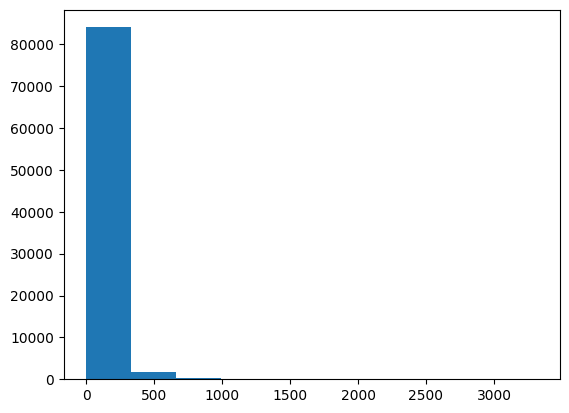

In [181]:
plt.hist(x=df['target'])
plt.show()

<Axes: xlabel='status', ylabel='target'>

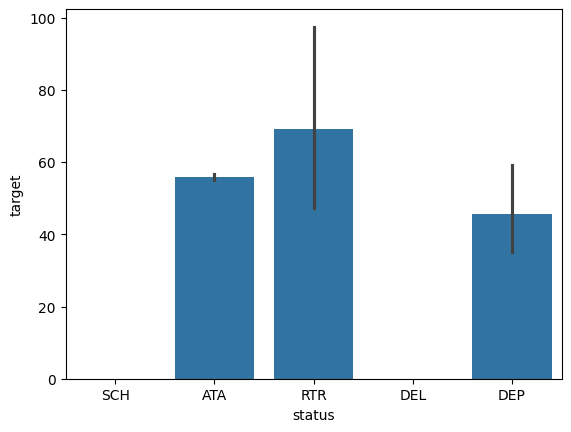

In [182]:
sns.barplot(df,x='status',y='target')

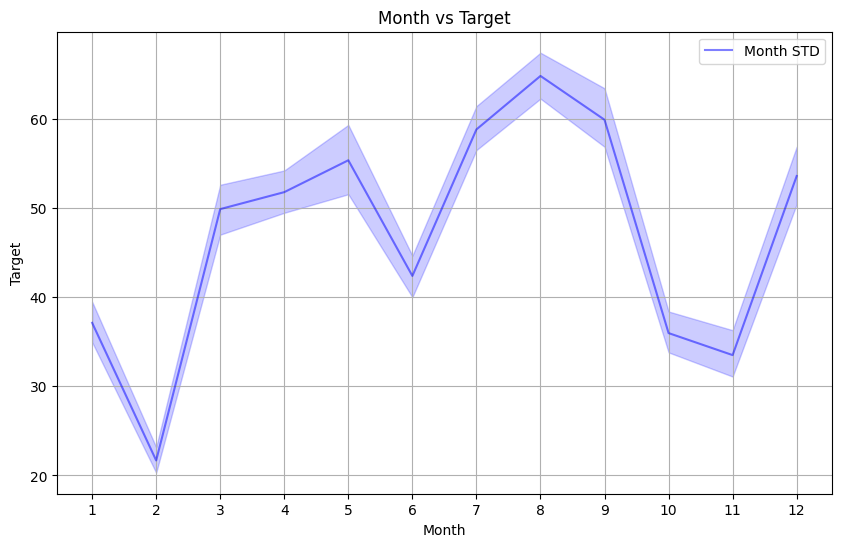

In [183]:
plt.figure(figsize=(10, 6))

# Plot month_std
sns.lineplot(x=df['month_std'], y=df['target'], label='Month STD', color='blue', alpha=0.5)

plt.title('Month vs Target')
plt.xlabel('Month')
plt.ylabel('Target')
plt.grid()
plt.xticks(range(1, 13))  # Assuming months are numbered 1 to 12
plt.legend()
plt.show()


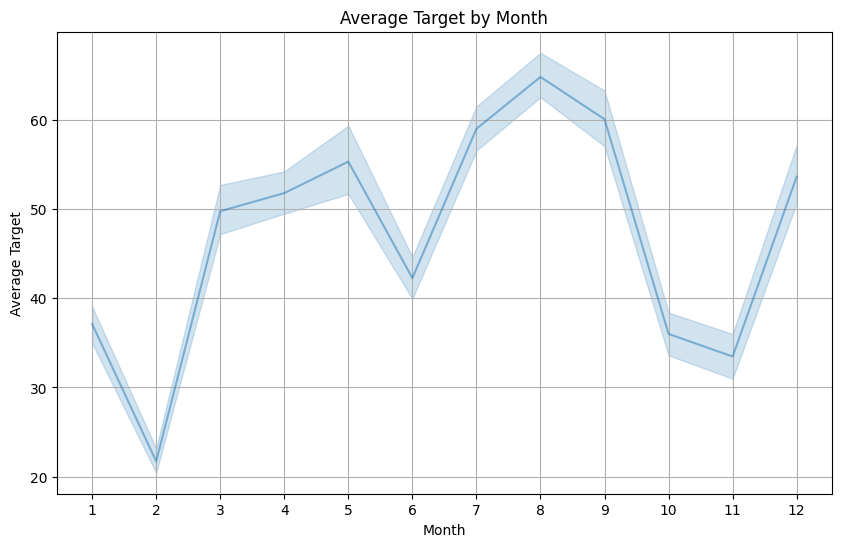

In [184]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='month_sta', y='target', alpha=0.5)
plt.title('Average Target by Month')
plt.xlabel('Month')
plt.ylabel('Average Target')
plt.grid()
plt.xticks(range(1, 13))  # Assuming months are numbered 1 to 12
plt.show()


In [185]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Create a new column for seasons
df['season'] = df['month_std'].apply(get_season)

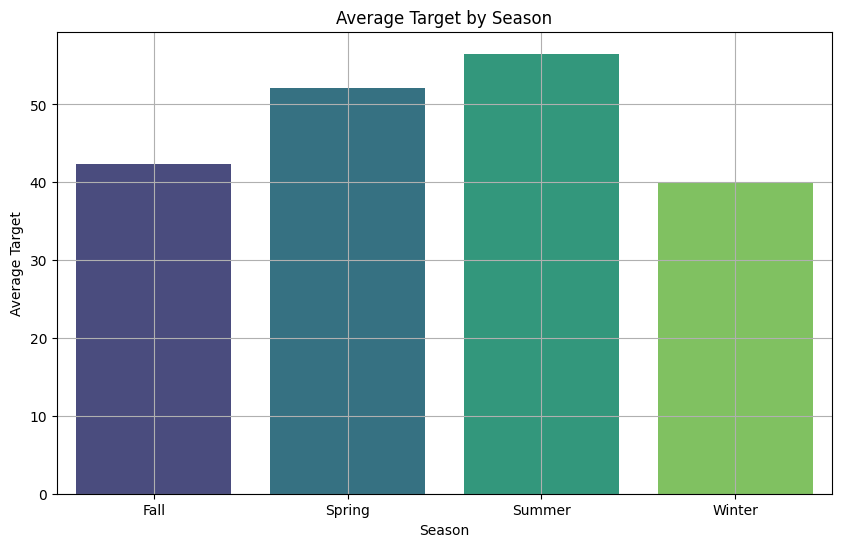

In [186]:
season_avg = df.groupby('season')['target'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=season_avg, x='season', y='target', palette='viridis')
plt.title('Average Target by Season')
plt.xlabel('Season')
plt.ylabel('Average Target')
plt.grid()
plt.show()

In [187]:
df_Cp=df.copy()
columns_drop=['id','datop','std', 'sta']
df_Cp.drop(columns=columns_drop,inplace=True)

##  Preprocessing

In [188]:
categorical_features=[ col_name for col_name in df_Cp.columns if df[col_name].dtype=='object']
neumeric_features=[ col_name for col_name in df_Cp.columns if df[col_name].dtype!='object' and col_name!='target']
print(categorical_features,'\n',
      neumeric_features)

['fltid', 'depstn', 'arrstn', 'status', 'ac', 'season'] 
 ['year_std', 'month_std', 'day_std', 'year_sta', 'month_sta', 'day_sta']


In [214]:
X=df_Cp.drop(columns=['target'])
y=df_Cp['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
num_pipeline = Pipeline(
                steps=[
                    ('scaler', StandardScaler()),
                ]
            )

cat_pipeline = Pipeline(
    steps=[
          ('cat', ce.CatBoostEncoder())
        , ('scaler', StandardScaler())
    ]
)


pipe_line_processor=ColumnTransformer(
              transformers= [('num_pipeline',num_pipeline,neumeric_features),
              ('cat_pipeline',cat_pipeline,categorical_features)
                             ]    )




In [215]:
#post analysis
Xtrain_inc_df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
del_indices = Xtrain_inc_df.index[Xtrain_inc_df['status'] == 'DEL'].tolist()[0]
row_duplicate=Xtrain_inc_df.loc[[del_indices]]
row_duplicate
duplicates = pd.concat([row_duplicate] * 100, ignore_index=True)
X_train_inc = pd.concat([Xtrain_inc_df, duplicates],ignore_index=True)
X_train_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69112 entries, 0 to 69111
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fltid      69112 non-null  object 
 1   depstn     69112 non-null  object 
 2   arrstn     69112 non-null  object 
 3   status     69112 non-null  object 
 4   ac         69112 non-null  object 
 5   year_std   69112 non-null  int32  
 6   month_std  69112 non-null  int32  
 7   day_std    69112 non-null  int32  
 8   year_sta   69112 non-null  int32  
 9   month_sta  69112 non-null  int32  
 10  day_sta    69112 non-null  int32  
 11  season     69112 non-null  object 
 12  target     69112 non-null  float64
dtypes: float64(1), int32(6), object(6)
memory usage: 5.3+ MB


In [216]:
X_train=X_train_inc.iloc[:,:-1]
y_train=X_train_inc.iloc[:,-1]
X_train_array=pipe_line_processor.fit_transform(X_train,y_train)
X_test_array=pipe_line_processor.transform(X_test)



In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define your models
models = {
    
    'rforest': RandomForestRegressor()
}

models_reports = {}

for model_name, model_obj in models.items():
    # Fit the model
    model_obj.fit(X_train_array, y_train)

    # Predictions
    y_train_predict = model_obj.predict(X_train_array)
    y_test_predict = model_obj.predict(X_test_array)

    # Calculate R² scores
    train_model_score = r2_score(y_train, y_train_predict)
    test_model_score = r2_score(y_test, y_test_predict)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))

    # Store the reports
    models_reports[model_name] = {
        'train_model_score': train_model_score,
        'test_model_score': test_model_score,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }
    # import shap
    # explainer = shap.Explainer(model_obj, X_train_array)
    # shap_values = explainer(X_test_array)

    # # Plot SHAP summary
    # shap.summary_plot(shap_values, X_test_array)

# Find the best model based on test R² score
best_model, best_score = max(models_reports.items(), key=lambda item: item[1]['test_model_score'])
print(f"Best Model: {best_model}, Best Score: {best_score['test_model_score']}, Test RMSE: {best_score['test_rmse']}")


ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.

In [221]:
pip install shap

Note: you may need to restart the kernel to use updated packages.Collecting shap
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/04/58/b2ea558ec8d9ed3728e83dfacb1b920c54a1a1f6feee2632c04676c3c1e9/shap-0.46.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/ca/bd/0fe29fcd1b6a8de479a4ed25c6e56470e467e3611c079d55869ceef2b6d1/numba-0.60.0-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Obtaining dependency informati


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [219]:

df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_predict
})

# Concatenate with X_test
df = pd.concat([X_test.reset_index(drop=True), df.reset_index(drop=True)], axis=1)

# Display the first few rows of the DataFrame
df[df['status']=='DEL']


,fltid,depstn,arrstn,status,ac,year_std,month_std,day_std,year_sta,month_sta,day_sta,season,Actual,Predicted
982,UG 1311,CDG,TUN,DEL,TU CR9ISA,2016,8,28,2016,8,28,Summer,0.0,0.00
2097,UG 1312,SFA,CDG,DEL,TU CR9ISA,2016,7,20,2016,7,20,Summer,0.0,27.41
2139,UG 1201,LYS,NTE,DEL,TU CR9ISA,2018,7,28,2018,7,28,Summer,0.0,0.00
5968,UG 1311,CDG,TUN,DEL,TU CR9ISA,2016,6,5,2016,6,5,Summer,0.0,0.00
7328,UG 0003,DJE,TUN,DEL,TU CR9ISA,2016,8,12,2016,8,12,Summer,0.0,0.00
8463,UG 0030,TUN,TOE,DEL,UG CR9ISA,2017,11,17,2017,11,17,Fall,0.0,0.00
9635,UG 0009,DJE,TUN,DEL,TU CR9ISA,2016,11,14,2016,11,14,Fall,0.0,0.00
11427,UG 0003,DJE,TUN,DEL,TU CR9ISA,2018,7,6,2018,7,6,Summer,0.0,0.00
11694,UG 0009,DJE,TUN,DEL,UG AT7AT7,2018,8,29,2018,8,29,Summer,0.0,0.00
12117,UG 0010,TUN,DJE,DEL,UG CR9ISA,2017,11,10,2017,11,10,Fall,0.0,0.00


##### Apply some techniques for showing the impact of the features on the model after traning
- Permutation Improvment
- Partial Dependency
- SHAP Analysis

-  Partial Dependency

In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(pipeline_res.named_steps['model'], X_test_transformed)
shap_values = explainer(X_test_transformed)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=pipeline_res.named_steps['preprocessor'].get_feature_names_out())
